In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import openpyxl

In [2]:
file_path = os.path.join('..', 'raw data', '20240901')
dir_list = list(filter(lambda x: os.path.isdir(os.path.join(file_path, x)),
                       os.listdir(file_path)))
file_path = os.path.join(file_path, dir_list[2])
file_list = os.listdir(file_path)
FormingDC_file_list = list(filter(lambda x: ' FormingDC' in x, file_list))
SetDC_file_list = list(filter(lambda x: ' SetDC' in x, file_list))
ResetDC_file_list = list(filter(lambda x: ' ResetDC' in x, file_list))
read_file_list = list(filter(lambda x: ' read' in x, file_list))
file_list = list(filter(lambda x: ' FormingDC' in x or ' SetDC' in x
                        or ' ResetDC' in x, file_list))
fig_title = file_path.split('/')[-1].split('(')[0]

df = [[], [], [], []]
for index, file in enumerate(file_list, start=1):
    curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
        else pd.read_excel(os.path.join(file_path, file))
    length = curr_df.shape[0]
    df[0].extend(curr_df.Vd.values)
    df[1].extend(curr_df.Id.values)
    df[2].extend([index] * length)
    operation = (['Forming'] if ' FormingDC' in file
                 else ['Set'] if ' SetDC' in file
                 else ['Reset'] if ' ResetDC' in file else None)
    df[3].extend(operation * length)
df = pd.DataFrame(np.transpose(df),
                  columns=['Vd (V)', 'Id (A)', 'Device', 'Operation'])
df['Vd (V)'] = pd.to_numeric(df['Vd (V)'])
df['Id (A)'] = pd.to_numeric(df['Id (A)'])
df['abs(Id)'] = abs(df['Id (A)'])
df['Resistance (Ohm)'] = \
    abs(df['Vd (V)'] / df['Id (A)']).where(df['Vd (V)'] != 0)

figsize = (5, 5)

In [3]:
print(file_path)
print(pd.Series(dir_list).head(99))
print(fig_title)

../raw data/20240901/LSMO3+5_390C_00(excel檔名的厚度打反了)
0                   LSMO3+3_390C_77
1              LSMO3+3_390C_77_xlsx
2    LSMO3+5_390C_00(excel檔名的厚度打反了)
3                  LSMO5+10_200C_10
4                   LSMO5+5_200C_10
5                   LSMO5+5_200C_12
6                   LSMO5+5_200C_13
7                   LSMO5+5_200C_15
8                   LSMO5+5_200C_31
9                     STO5+5_200_16
dtype: object
LSMO3+5_390C_00


In [4]:
if len(FormingDC_file_list) != 0:
    forming_df = df[df.Operation == 'Forming']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.lineplot(data=forming_df, x='Vd (V)', y='Id (A)', estimator=None,
                 sort=False)
    plt.title("Forming(linear)")
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.lineplot(data=forming_df, x='Vd (V)', y='Id (A)', estimator=None,
                 sort=False)
    ax.set(title="Forming(log)", yscale='log')
    plt.show()

99 99


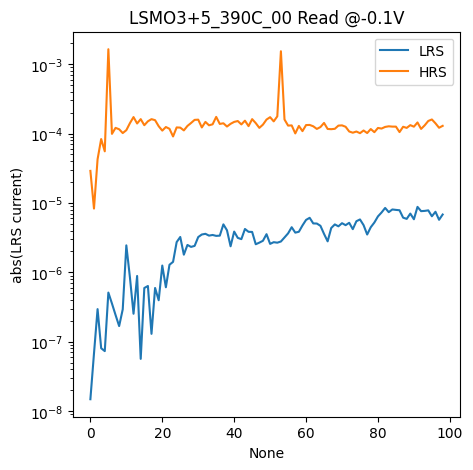

In [5]:
lrs_file_list = list(filter(lambda x: ' read1' in x, read_file_list))
hrs_file_list = list(filter(lambda x: ' read2' in x, read_file_list))
read_df = [[], []]
for index, file in enumerate(lrs_file_list):
    curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
        else pd.read_excel(os.path.join(file_path, file))
    try:
        read_df[0].append(curr_df.values[1][1])
    except IndexError:
        print('Failing reading file:', file)
        print(curr_df)

for index, file in enumerate(hrs_file_list):
    curr_df = pd.read_csv(os.path.join(file_path, file)) if 'csv' in file \
        else pd.read_excel(os.path.join(file_path, file))
    try:
        read_df[1].append(curr_df.values[1][1])
    except IndexError:
        print('Failing reading file:', file)
        print(curr_df)

print(len(read_df[0]), len(read_df[1]))
read_df = pd.DataFrame(
    np.array(read_df).T,
    columns=["LRS current", "HRS current"],
    dtype=np.float64
)
read_df["abs(LRS current)"] = abs(read_df["LRS current"])
read_df["abs(HRS current)"] = abs(read_df["HRS current"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(yscale='log', title=f'{fig_title} Read @-0.1V', xlabel='')
sns.lineplot(x=read_df.index, y=read_df["abs(LRS current)"], label="LRS", ax=ax)
sns.lineplot(x=read_df.index, y=read_df["abs(HRS current)"], label="HRS", ax=ax)
plt.legend()
plt.savefig(f'tmp/{fig_title}_read.png')
plt.show()

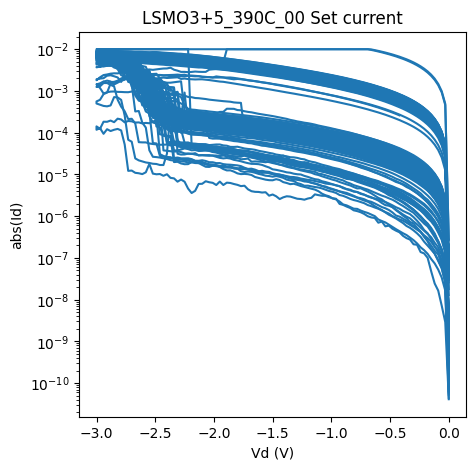

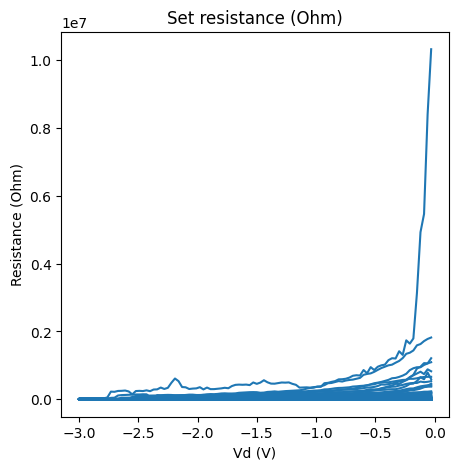

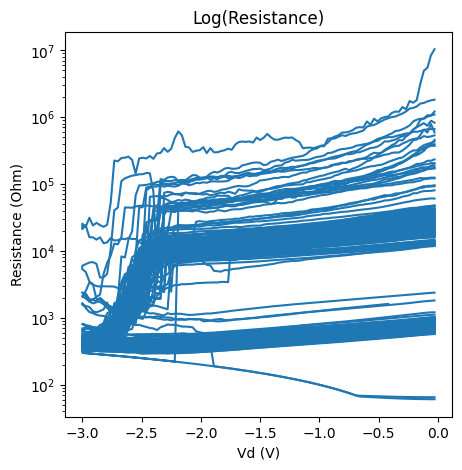

In [6]:
Set_df = df[df.Operation == 'Set']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title=f'{fig_title} Set current', yscale='log')
sns.lineplot(data=Set_df, x='Vd (V)', y='abs(Id)', units='Device',
             estimator=None, sort=False, ax=ax)
plt.savefig(f'tmp/{fig_title}_set.png')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title="Set resistance (Ohm)")
sns.lineplot(data=Set_df, x='Vd (V)', y='Resistance (Ohm)', units='Device',
             estimator=None, sort=False)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title="Log(Resistance)", yscale='log')
sns.lineplot(data=Set_df, x='Vd (V)', y='Resistance (Ohm)', units='Device',
             estimator=None, sort=False)
plt.show()

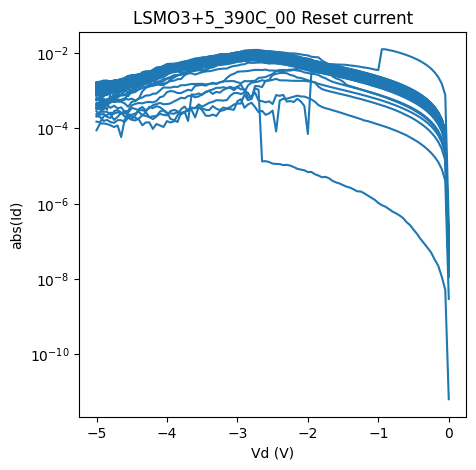

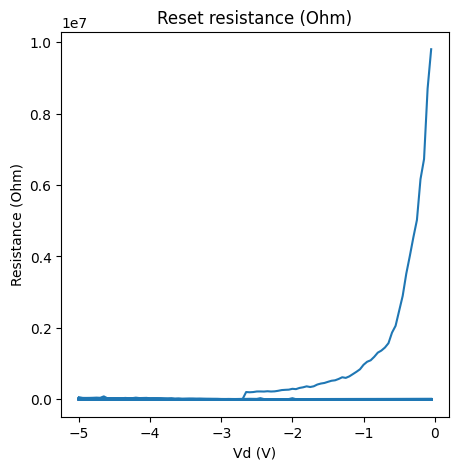

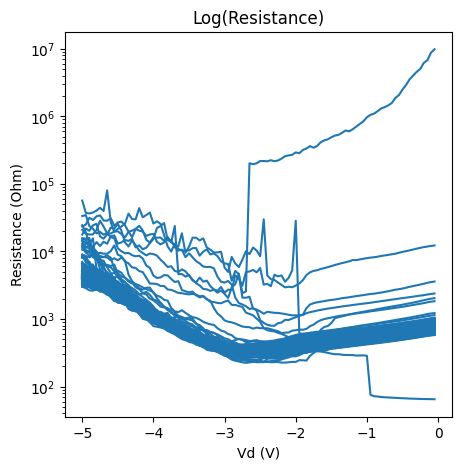

In [7]:
Reset_df = df[df.Operation == 'Reset']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title=f'{fig_title} Reset current', yscale='log')
sns.lineplot(data=Reset_df, x='Vd (V)', y='abs(Id)', units='Device',
             estimator=None, sort=False, ax=ax)
plt.savefig(f'tmp/{fig_title}_reset.png')
plt.show()
# for index in Reset_df.Device.unique():
#     fig = sns.lineplot(data=Reset_df[Reset_df.Device == index], x='Vd (V)', y='abs(Id)', estimator=None, sort=False)
#     fig.set(title=index, yscale='log')
#     plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title="Reset resistance (Ohm)")
sns.lineplot(data=Reset_df, x='Vd (V)', y='Resistance (Ohm)', units='Device',
             estimator=None, sort=False)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title="Log(Resistance)", yscale='log')
sns.lineplot(data=Reset_df, x='Vd (V)', y='Resistance (Ohm)', units='Device',
             estimator=None, sort=False)
plt.show()

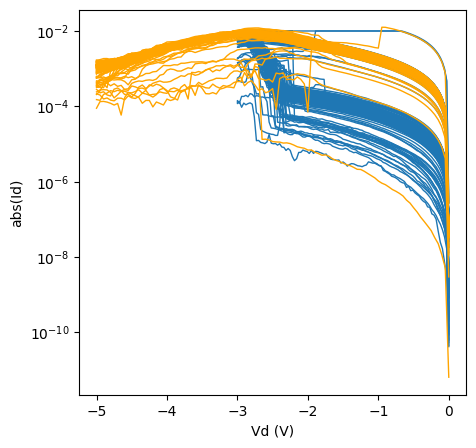

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set_yscale('log')
sns.lineplot(data=df[df.Operation == 'Set'], x='Vd (V)', y='abs(Id)',
             units='Device', color='#1f77b4', estimator=None, sort=False, lw=1,
             ax=ax)
sns.lineplot(data=df[df.Operation == 'Reset'], x='Vd (V)', y='abs(Id)',
             units='Device', color='orange', estimator=None, sort=False, lw=1,
             ax=ax)
plt.show()

99 99


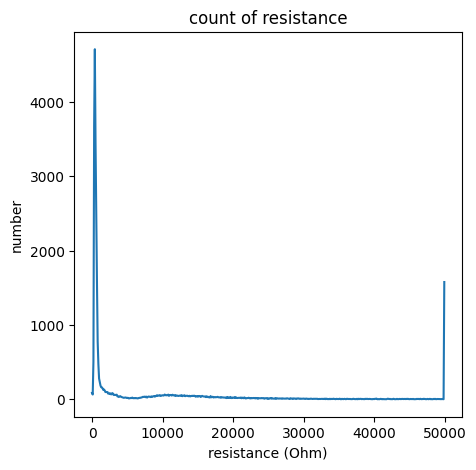

In [9]:
print(len(SetDC_file_list), len(ResetDC_file_list))
if (len(SetDC_file_list) != len(ResetDC_file_list)):
    raise IndexError("Set files and reset files doesn't match")

res = df['Resistance (Ohm)']
groups = list(range(0, 50000, 100))
groups.append(np.inf)
grouped = res.groupby(pd.cut(res, groups), observed=False).count()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set(title='count of resistance', xlabel='resistance (Ohm)', ylabel='number')
plt.plot(groups[:-1], grouped.values)
plt.show()

# palette = {"HRS": "#1f77b4", "LRS": "orange"}
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
# ax.set(title="Set", yscale='log')
# for index in df[df.Operation == 'Set'].Device.unique()[8:]:
#     sns.lineplot(data=df[df.Device == index], x="Vd (V)", y="Resistance (Ohm)",
#                  hue="State", units="State", palette=palette, estimator=None,
#                  sort=False, legend=None, lw=1, ax=ax)
# plt.show()

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
# ax.set(title="Reset", yscale='log')
# for index in df[df.Operation == 'Reset'].Device.unique()[8:]:
#     sns.lineplot(data=df[df.Device == index], x="Vd (V)", y="Resistance (Ohm)",
#                  hue="State", units="State", palette=palette, estimator=None,
#                  sort=False, legend=None, lw=1)
# plt.show()

# dx = df.iloc[1, 0] - df.iloc[0, 0]  # Vd[1] - Vd[0]
# df['d(res)/d(Vd)'] = np.gradient(df['Resistance (Ohm)'])
# df['d(res)/d(Vd)'] = df['d(res)/d(Vd)'].mask(df['Resistance (Ohm)'].isnull())
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
# ax.set(title="Reset")
# for index in df[df.Operation == 'Reset'].Device.unique():
#     sns.lineplot(data=df[df.Device == index], x="Vd (V)", y="d(res)/d(Vd)",
#                  units="State", estimator=None, sort=False, legend=None, lw=1,
#                  color='#1f77b4')
# plt.show()

# df['State'] = 'transforming'

In [11]:
print(df)
print(fig_title)
output_file = os.path.join("..", "Reports", "data.xlsx")
print(output_file)
with pd.ExcelWriter(output_file, mode="a", engine="openpyxl",
                    if_sheet_exists='replace') as writer:
    sheet_name = fig_title
    df.to_excel(writer, sheet_name=sheet_name, index=False)

    workbook = writer.book
    worksheet = writer.sheets[sheet_name]

    img = openpyxl.drawing.image.Image(f'tmp/{fig_title}_read.png')
    img.anchor = ('J2')
    worksheet.add_image(img)
    img = openpyxl.drawing.image.Image(f'tmp/{fig_title}_set.png')
    img.anchor = ('R2')
    worksheet.add_image(img)
    img = openpyxl.drawing.image.Image(f'tmp/{fig_title}_reset.png')
    img.anchor = ('Z2')
    worksheet.add_image(img)

       Vd (V)        Id (A) Device Operation       abs(Id)  Resistance (Ohm)
0        0.00  1.109060e-08      1     Reset  1.109060e-08               NaN
1       -0.05 -1.397080e-05      1     Reset  1.397080e-05       3578.893120
2       -0.10 -2.844580e-05      1     Reset  2.844580e-05       3515.457466
3       -0.15 -4.378610e-05      1     Reset  4.378610e-05       3425.744700
4       -0.20 -6.017760e-05      1     Reset  6.017760e-05       3323.495786
...       ...           ...    ...       ...           ...               ...
29978   -0.12 -1.568560e-04    198       Set  1.568560e-04        765.032896
29979   -0.09 -1.163440e-04    198       Set  1.163440e-04        773.568040
29980   -0.06 -7.684830e-05    198       Set  7.684830e-05        780.758976
29981   -0.03 -3.811860e-05    198       Set  3.811860e-05        787.017362
29982    0.00  4.666020e-08    198       Set  4.666020e-08               NaN

[29983 rows x 6 columns]
LSMO3+5_390C_00
../Reports/data.xlsx
